비젼 트랜스포머로 손글씨 인식하기


In [ ]:
# 1번 블록: 패키지 수입
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from time import time


In [ ]:
# 2번 블록: 하이퍼 파라미터 지정
MY_SHAPE = (1, 28, 28)         # 입력 이미지 형태 (MNIST: 흑백 28x28)
MY_EPOCH = 1                   # 학습 반복 횟수 (성능 향상 위해 5 이상 권장)
MY_BATCH = 128                # 배치 크기 (GPU 메모리에 따라 조절 가능)
MY_LEARNING = 0.005           # 학습률 (기본 Adam 기준, 너무 크면 발산 위험)

MY_PATCH = 7                  # 한 변을 나누는 패치 수 (7x7 → 총 49개 패치)
MY_ENCODER = 2                # 인코더 블록 수 (Transformer encoder layer 수)
MY_HIDDEN = 8                 # 패치 임베딩 차원 수 (작으면 연산량 작지만 표현력 제한됨)
MY_HEAD = 2                   # 멀티헤드 어텐션에서의 헤드 수 (각 head당 8/2=4차원)
MY_MLP = 3                    # MLP 확장 비율 (hidden → hidden×3 → hidden)
MY_CLASS = 10                 # 클래스 수 (MNIST: 숫자 0~9)

# GPU 사용 가능하면 GPU로 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 장치:", DEVICE)


사용 장치: cuda


In [ ]:

# 3번 블록: 이미지를 패치로 나눔
def patchify(images, n_patches):
    n, c, h, w = images.shape  # 예: [128, 1, 28, 28] → n=128, c=1, h=28, w=28
    patch_size = h // n_patches  # 28 // 7 = 4

    # 각 패치는 4x4 = 16 픽셀 → flatten 후 16차원 벡터
    # 총 패치 수: 7x7 = 49 → 출력 shape: [128, 49, 16]
    patches = torch.zeros(n, n_patches**2, h*w*c//n_patches**2, device=images.device)

    for idx, image in enumerate(images):
        for i in range(n_patches):  # 세로 방향 7개
            for j in range(n_patches):  # 가로 방향 7개
                patch = image[
                    :,
                    i * patch_size : (i+1) * patch_size,
                    j * patch_size : (j+1) * patch_size,
                ]  # patch shape: [1, 4, 4]
                patches[idx, i*n_patches + j] = patch.flatten()  # → [16]
    return patches


In [ ]:
# 4번 블럭
# multi-head attention 클래스 정의
# n_hidden: 임베딩 차원 수, 8
# n_heads: 머리 수, 2

class MyMSA(nn.Module):
    def __init__(self, n_hidden, n_heads):
        super(MyMSA, self).__init__()
        self.n_hidden = n_hidden
        self.n_heads = n_heads

        # 각 head가 처리할 차원, 4
        d_head = int(n_hidden / n_heads)
        self.d_head = d_head

        # Q, K, V 행렬 계산
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(n_heads)]
        )
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(n_heads)]
        )
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(n_heads)]
        )
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, images):
        # 입력 데이터 모양: [128, 50, 8]
        # 출력 데이터 모양: [128, 50, 8]

        # 128개 attention 결과 저장
        result = []
        for sequence in images:
            # 각 이미지 당 50개 패치의 계산 결과
            seq_result = []

            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                # 입력 데이터 모양: [50, 4]
                seq = sequence[:, head * self.d_head : (head+1) * self.d_head]

                # self attention 계산
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)
                #print('Q의 크기', len(q[0]))
                attention = self.softmax(q @ k.T / (self.d_head**0.5))
                attention = attention @ v
                #print('attention 크기', attention.shape)
                seq_result.append(attention)

            # hstack으로 두개의 head 결과 통합
            # [50, 4] + [50, 4] = [50, 8]
            merge = torch.hstack(seq_result)
            #print('통합 결과', merge.shape)

            # 현재 이미지 종료
            result.append(merge)

        # print('최종 배치 처리 결과', len(result))
        # 결과를 텐서로 전환
        final = [torch.unsqueeze(r, dim=0) for r in result]
        final = torch.cat(final)
        # print('attention 결과 데이터 모양', final.shape)

        return final



In [ ]:
# 5번 블록
# 인코더 구현

class MyEncoder(nn.Module):
  def __init__(self, n_hidden, n_heads):
    super(MyEncoder, self).__init__()

    # 패치 임베딩 차원
    self.n_hidden = n_hidden

    # 멀티헤드 에텐션 수
    self.n_heads = n_heads

    # 첫번째 layer normalization 층
    self.norm1 = nn.LayerNorm(n_hidden)

    # multi-head attention layer
    self.msa = MyMSA(n_hidden, n_heads)

    # 두번째 layer normalization layer
    self.norm2 = nn.LayerNorm(n_hidden)

    # 최종 multi-layer perceptron layer
    self.mlp = nn.Sequential(
        nn.Linear(n_hidden,  MY_MLP * n_hidden),
        nn.GELU(),  #가우시안 함수가 음수영역에 적용된 형태의 RELU 변형
        nn.Linear(MY_MLP * n_hidden, n_hidden)
    )

  def forward(self, x):
    out = x + self.msa(self.norm1(x))
    out = self.norm2(out) + self.mlp(self.norm2(out))
    return out


In [ ]:
# 6번 블록

class MyVIT(nn.Module):
    def __init__(self, n_patches, n_encoder, n_hidden, n_heads, n_class, image_shape=(1, 28, 28)):
        super(MyVIT, self).__init__()

        self.n_patches = n_patches
        self.n_encoder = n_encoder
        self.n_heads = n_heads
        self.n_hidden = n_hidden

        # 한 패치의 화소 수 = (패치 한 변의 길이)^2
        self.input_d = (image_shape[1] // n_patches) ** 2
        print("패치 화소 수 :", self.input_d)

        # 입력 차원(input_d) → 임베딩 차원(n_hidden)으로 변환
        self.linear_mapper = nn.Linear(self.input_d, n_hidden)

        # 학습 가능한 CLS 토큰 추가: [1, 1, n_hidden]
        self.class_token = nn.Parameter(torch.rand(1, 1, n_hidden))
        print("CLS 토큰 모양 :", self.class_token.shape)

        # 포지셔널 인코딩: [1, 패치수+1, n_hidden]
        self.pos_embedding = nn.Parameter(torch.randn(1, n_patches**2 + 1, n_hidden))

        # 인코더 블록 여러 개 쌓기
        self.encoder = nn.Sequential(*[
            MyEncoder(n_hidden, n_heads) for _ in range(n_encoder)
        ])

        # 최종 분류기
        self.mlp_head = nn.Linear(n_hidden, n_class)

    def forward(self, images):
        """
        images: [B, C, H, W] → patchify 필요
        """
        B = images.shape[0]

        # 이미지를 패치 시퀀스로 변환 (patchify 함수 선행 필요)
        x = patchify(images, self.n_patches)  # [B, num_patches, patch_dim]
        x = self.linear_mapper(x)             # [B, num_patches, n_hidden]

        # CLS 토큰 복제 및 붙이기
        cls_tokens = self.class_token.expand(B, -1, -1)  # [B, 1, n_hidden]
        x = torch.cat((cls_tokens, x), dim=1)            # [B, num_patches+1, n_hidden]

        # 포지셔널 인코딩 추가
        x = x + self.pos_embedding  # [B, 50, n_hidden]

        # 인코더 통과
        x = self.encoder(x)         # [B, 50, n_hidden]

        # CLS 토큰만 추출 → 최종 분류
        cls_out = x[:, 0]           # [B, n_hidden]
        logits = self.mlp_head(cls_out)  # [B, n_class]

        return logits


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.07MB/s]


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([1

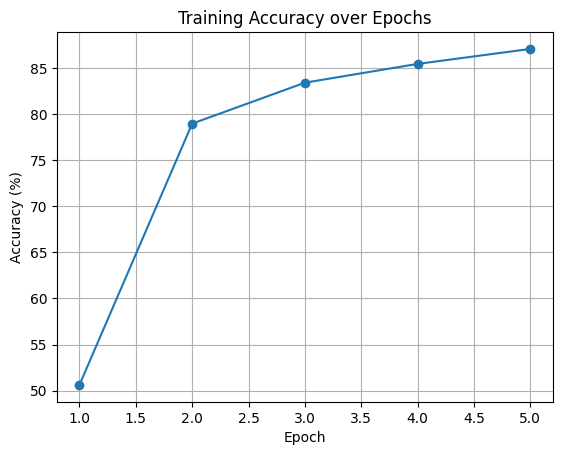

최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attentio

In [ ]:
# 7번 블록: 학습 루프 + 테스트 평가 + 정확도 그래프
train_dataset = MNIST(root="./", train=True, download=True, transform=ToTensor())
test_dataset = MNIST(root="./", train=False, download=True, transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=MY_BATCH, shuffle=True)  # batch_size = 128
test_loader = DataLoader(test_dataset, batch_size=MY_BATCH)

model = MyVIT(
    n_patches=MY_PATCH,        # 7
    n_encoder=MY_ENCODER,      # 2
    n_hidden=MY_HIDDEN,        # 8
    n_heads=MY_HEAD,           # 2
    n_class=MY_CLASS,          # 10
    image_shape=MY_SHAPE       # (1, 28, 28)
).to(DEVICE)

criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=MY_LEARNING)  # 학습률: 0.005

# 학습 기록용 리스트
train_accuracies = []

model.train()
start = time()

MY_EPOCH = 5

for epoch in range(MY_EPOCH):  # 총 5 에폭
    epoch_loss = 0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # GPU로 전송
        outputs = model(images)  # 출력 shape: [128, 10]
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    train_accuracies.append(accuracy)
    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f} | Accuracy: {accuracy:.2f}%")

print("총 학습 시간:", round(time() - start, 2), "초")

# 정확도 그래프 출력
plt.plot(range(1, MY_EPOCH + 1), train_accuracies, marker='o')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

# 테스트 평가
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"[Test Accuracy] {100 * correct / total:.2f}%")



##DrLoc : Dense relative location 적용  
✅ DrLoc란?
**Dense Relative Localization (DrLoc)**는
이미지 패치들 간의 상대적인 위치 정보를 예측하도록 학습을 유도하는
**보조 학습 목표(auxiliary objective)**입니다.

🎯 기본 아이디어
Transformer는 본래 위치 정보를 직접 학습하지 않기 때문에,
위치 인코딩 없이 학습하면 구조적인 공간 정보를 잘 못 잡을 수 있음.

DrLoc은 이를 해결하기 위해:

두 이미지 패치가 얼마나 떨어져 있는지를 예측하는 task를 부여

즉, 패치 i, j 쌍에 대해:

“패치 i는 패치 j로부터 얼마나 떨어져 있는가?”

를 예측하게 하여
Transformer가 상대적 위치 감각을 학습하게 함

🧠 왜 중요한가?
기존 ViT 문제점	DrLoc이 해결하는 부분
위치 인코딩 없으면 공간 정보 손실	상대 위치를 예측함으로써 위치 감각 학습
Self-attention은 permutation-invariant	위치 차이 자체를 supervision으로 사용
순수 classification은 학습이 어려움	보조 태스크로 학습을 안정화시킴



In [ ]:
# 7번 블록: 학습 루프 + 테스트 평가 + 정확도 그래프
train_dataset = MNIST(root="./", train=True, download=True, transform=ToTensor())
test_dataset = MNIST(root="./", train=False, download=True, transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=MY_BATCH, shuffle=True)  # batch_size = 128
test_loader = DataLoader(test_dataset, batch_size=MY_BATCH)

model = MyVIT(
    n_patches=MY_PATCH,        # 7
    n_encoder=MY_ENCODER,      # 2
    n_hidden=MY_HIDDEN,        # 8
    n_heads=MY_HEAD,           # 2
    n_class=MY_CLASS,          # 10
    image_shape=MY_SHAPE       # (1, 28, 28)
).to(DEVICE)

criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=MY_LEARNING)  # 학습률: 0.005


MY_EPOCH = 5


# === 전체 기존 코드 생략 (1~6번 블록) ===
# 7번 블록의 확장: DrLoc loss 추가 및 성능 비교

# DrLoc 보조 손실 함수 구현
# 입력: [B, N, D] - Transformer 출력 임베딩 (CLS 포함)
# N = 50 (49 패치 + 1 CLS)

def drloc_loss(patch_embeddings):
    B, N, D = patch_embeddings.shape
    device = patch_embeddings.device

    # 위치 정보 만들기 (7x7 위치로 가정)
    coords = torch.stack(torch.meshgrid(torch.arange(7), torch.arange(7), indexing="ij"), dim=-1)
    coords = coords.reshape(-1, 2).to(device)  # [49, 2]
    coords = coords / 6.0  # 정규화: 0~1

    # CLS 토큰 제거하고 [B, 49, D]
    patch_only = patch_embeddings[:, 1:, :]

    # Cosine 유사도 기반 거리 예측
    normed = patch_only / (patch_only.norm(dim=2, keepdim=True) + 1e-6)
    similarity = normed @ normed.transpose(1, 2)  # [B, 49, 49]

    # 실제 상대 거리 라벨 만들기
    dist = coords[None, :, None, :] - coords[None, None, :, :]  # [1, 49, 49, 2]
    dist = torch.norm(dist, dim=-1)  # [1, 49, 49]
    dist = 1 - dist / dist.max()  # 거리를 0~1 → 1~0로 뒤집음

    # MSE 손실 계산
    mse = (similarity - dist) ** 2
    loss = mse.mean()
    return loss


# === 기존 학습 루프 확장 ===
train_accuracies = []
model.train()
start = time()

drloc_weight = 0.2  # DrLoc 손실 가중치 (하이퍼파라미터)

for epoch in range(MY_EPOCH):
    epoch_loss = 0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # patchify & embedding
        x = patchify(images, MY_PATCH)            # [B, 49, 16]
        x = model.linear_mapper(x)                # [B, 49, 8]
        cls_tokens = model.class_token.expand(x.size(0), -1, -1)  # [B, 1, 8]
        x = torch.cat((cls_tokens, x), dim=1)     # [B, 50, 8]
        x = x + model.pos_embedding

        # 인코더 통과
        encoded = model.encoder(x)                # [B, 50, 8]

        # 분류 예측
        cls_out = encoded[:, 0]                   # [B, 8]
        outputs = model.mlp_head(cls_out)         # [B, 10]

        # 분류 손실
        loss_cls = criterion(outputs, labels)

        # DrLoc 보조 손실
        loss_drloc = drloc_loss(encoded.detach())  # detach()로 주 네트워크에는 영향 X

        # 전체 손실 = 분류 손실 + 위치 손실
        loss = loss_cls + drloc_weight * loss_drloc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss_cls.item()  # 메인 손실 기준 기록
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    train_accuracies.append(accuracy)
    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f} | Accuracy: {accuracy:.2f}%")

print("총 학습 시간:", round(time() - start, 2), "초")

# 정확도 그래프 출력
plt.plot(range(1, MY_EPOCH + 1), train_accuracies, marker='o')
plt.title("Training Accuracy over Epochs (with DrLoc)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

# 테스트 성능 평가
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"[Test Accuracy with DrLoc] {100 * correct / total:.2f}%")


패치 화소 수 : 16
CLS 토큰 모양 : torch.Size([1, 1, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 torch.Size([128, 50, 8])
최종 배치 처리 결과 128
attention 결과 데이터 모양 to